In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import dates as mpl_dates
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
random.seed(123)
import os

from sklearn.model_selection import train_test_split



## Data Checks

In [2]:
#load data
merge_csv = pd.read_csv('data/merged_data.csv', parse_dates=['DataDate'])
merge_csv.head()

,DataDate,PM2.5,PM2_5,Temp,Hum
0,2023-08-25 06:01:00,18.07556,28.0,0.0,0.0
1,2023-08-25 06:02:00,18.32117,26.0,0.0,0.0
2,2023-08-25 06:03:00,18.42729,26.0,0.0,0.0
3,2023-08-25 06:04:00,18.44625,29.0,0.0,0.0
4,2023-08-25 06:05:00,18.59127,26.0,0.0,0.0


In [3]:
merge_csv.isna().sum()

DataDate    0
PM2.5       0
PM2_5       0
Temp        0
Hum         0
dtype: int64

In [4]:
merge_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DataDate  1587 non-null   datetime64[ns]
 1   PM2.5     1587 non-null   float64       
 2   PM2_5     1587 non-null   float64       
 3   Temp      1587 non-null   float64       
 4   Hum       1587 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 62.1 KB


In [5]:
merge_csv.describe()

,DataDate,PM2.5,PM2_5,Temp,Hum
count,1587,1587.000000,1587.000000,1587.000000,1587.000000
mean,2023-08-25 20:47:13.194707200,10.903018,11.655955,18.507687,74.361166
min,2023-08-25 06:01:00,5.479650,0.000000,0.000000,0.000000
25%,2023-08-25 13:55:30,8.018629,6.000000,21.500000,77.000000
50%,2023-08-25 21:05:00,9.364429,8.000000,21.900000,94.000000
75%,2023-08-26 03:51:30,12.075205,13.000000,23.400000,99.320000
max,2023-08-26 10:41:00,25.960430,44.000000,30.700000,100.000000
std,NaN,4.331167,8.279639,9.605301,38.400237


In [6]:
merge_csv.shape

(1587, 5)

In [7]:
merge_csv.columns

Index(['DataDate', 'PM2.5', 'PM2_5', 'Temp', 'Hum'], dtype='object')

In [8]:
merge_csv.duplicated().sum()

0

In [9]:
merge_csv.nunique()

DataDate    1587
PM2.5       1587
PM2_5         44
Temp          86
Hum           84
dtype: int64

In [10]:
## define numerical columes
numeric_features = [feature for feature in merge_csv.columns if merge_csv[feature].dtype != 'O']
categorical_features = [feature for feature in merge_csv.columns if merge_csv[feature].dtype == 'O']

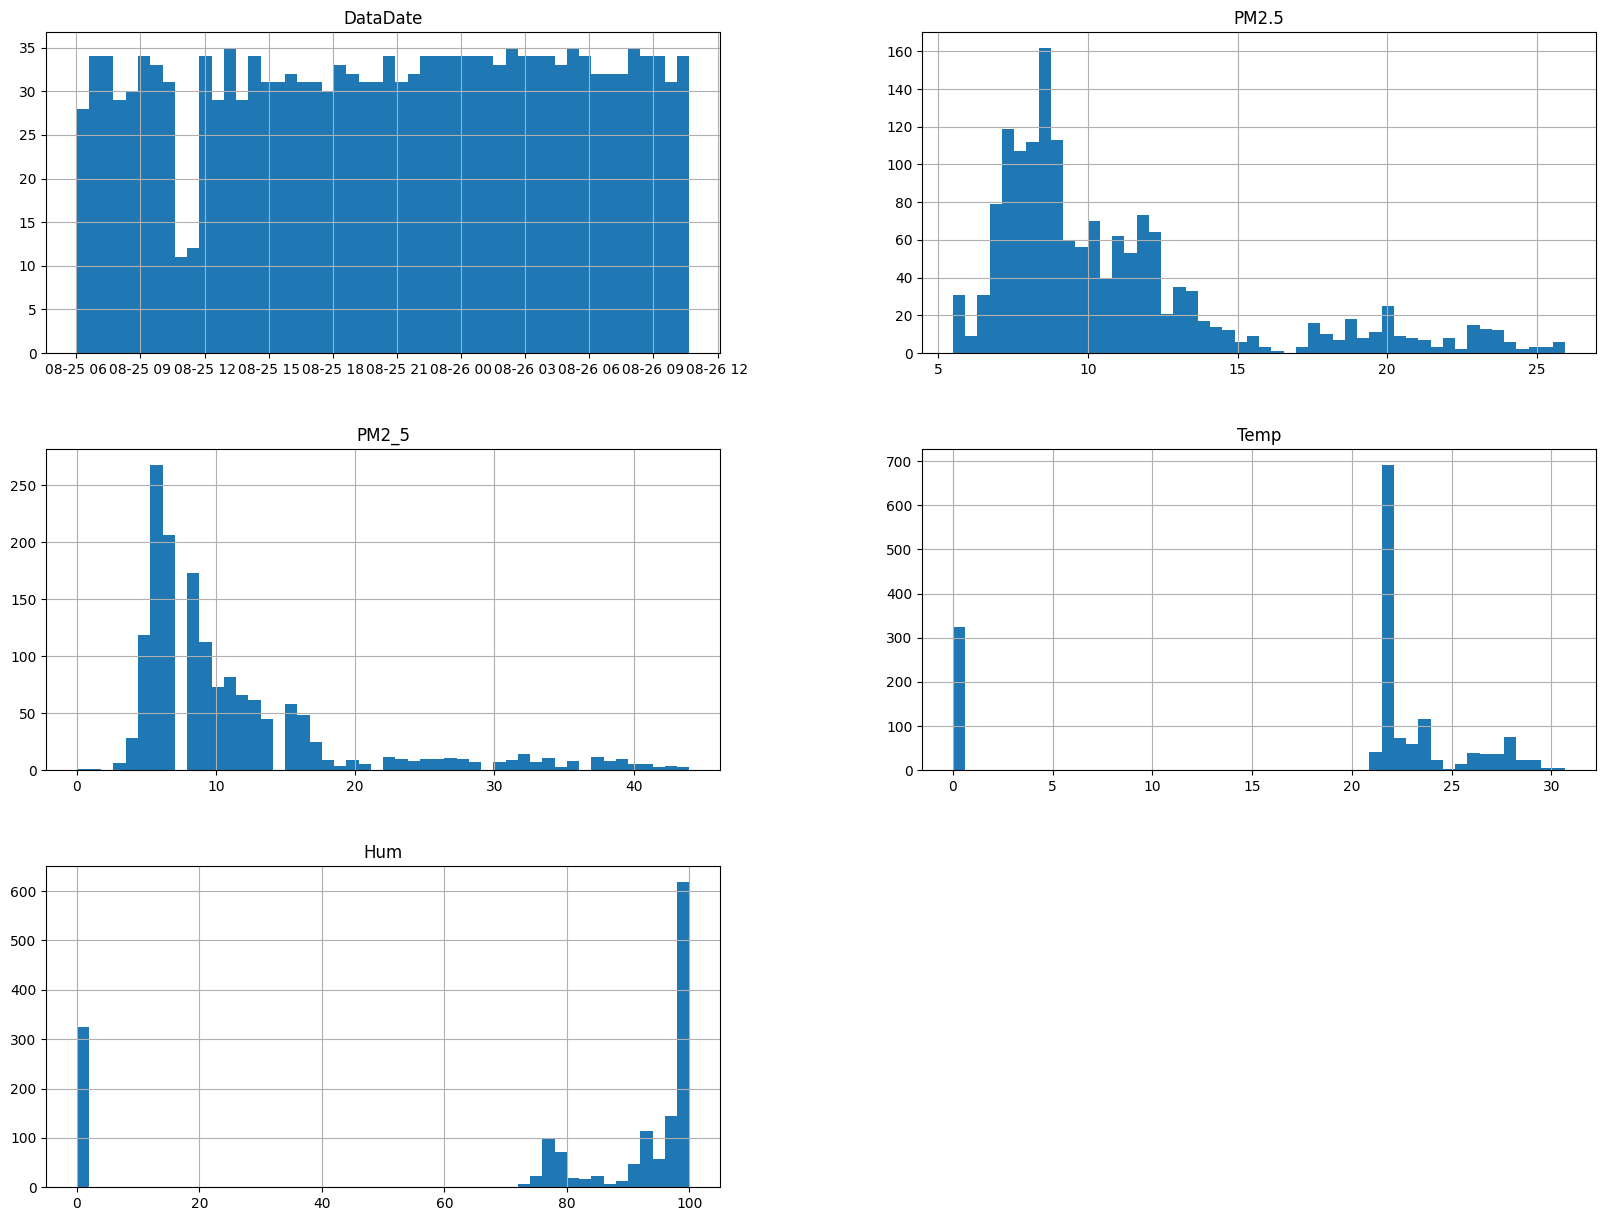

In [11]:
%matplotlib inline
merge_csv.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
train_set, test_set = train_test_split(merge_csv, test_size=0.2, random_state=485645)
train_set

,DataDate,PM2.5,PM2_5,Temp,Hum
575,2023-08-25 17:09:00,8.595349,6.0,25.7,84.00
219,2023-08-25 09:59:00,11.919960,15.0,0.0,0.00
788,2023-08-25 21:00:00,7.303940,6.0,21.8,99.00
892,2023-08-25 22:50:00,9.391881,13.0,22.0,97.00
387,2023-08-25 13:44:00,8.846948,9.0,27.4,78.00
...,...,...,...,...,...
609,2023-08-25 17:50:00,9.007333,7.0,22.8,91.00
1539,2023-08-26 09:51:00,11.288230,8.0,23.9,91.00
226,2023-08-25 10:06:00,11.769080,15.0,0.0,0.00
1293,2023-08-26 05:36:00,12.707380,19.0,21.4,99.58


In [13]:
train_set.shape

(1269, 5)

In [14]:
test_set.head()

,DataDate,PM2.5,PM2_5,Temp,Hum
83,2023-08-25 07:31:00,24.19335,37.0,0.0,0.0
240,2023-08-25 10:20:00,15.37881,17.0,0.0,0.0
755,2023-08-25 20:27:00,6.95343,6.0,21.8,99.0
140,2023-08-25 08:38:00,17.73177,22.0,0.0,0.0
964,2023-08-26 00:03:00,11.37309,11.0,21.8,99.0


In [15]:
test_set.shape

(318, 5)

In [16]:
calibration_df = train_set.copy()
calibration_df.head()

,DataDate,PM2.5,PM2_5,Temp,Hum
575,2023-08-25 17:09:00,8.595349,6.0,25.7,84.0
219,2023-08-25 09:59:00,11.919960,15.0,0.0,0.0
788,2023-08-25 21:00:00,7.303940,6.0,21.8,99.0
892,2023-08-25 22:50:00,9.391881,13.0,22.0,97.0
387,2023-08-25 13:44:00,8.846948,9.0,27.4,78.0


In [17]:
corr_matrix = calibration_df.corr()
corr_matrix['PM2_5']

DataDate   -0.520465
PM2.5       0.937203
PM2_5       1.000000
Temp       -0.760433
Hum        -0.737396
Name: PM2_5, dtype: float64

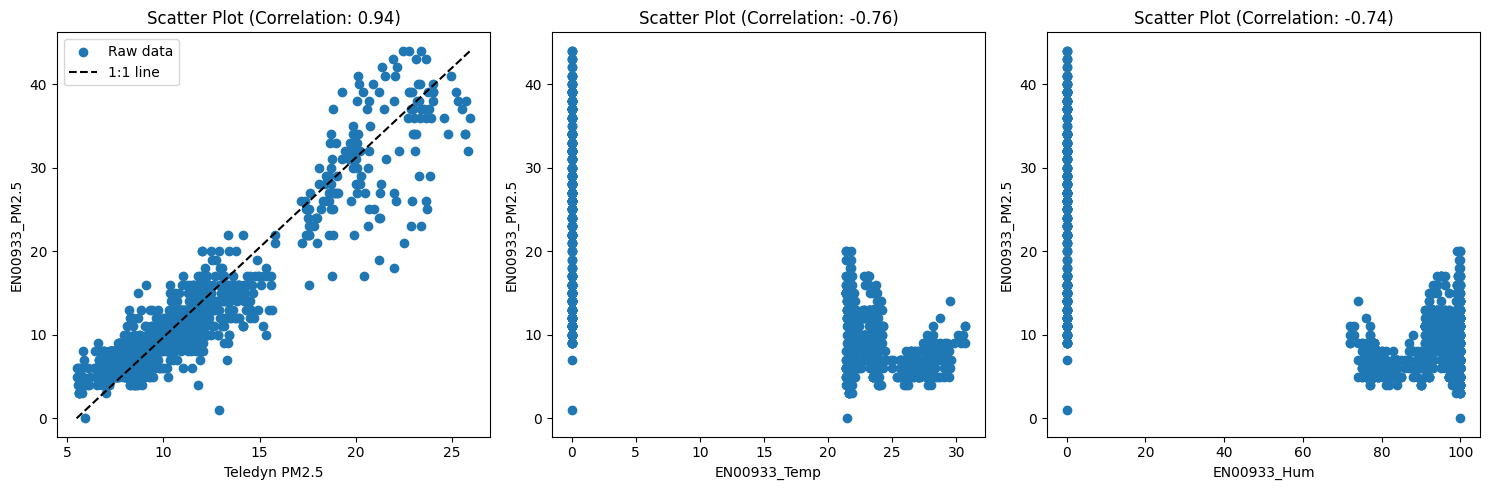

In [18]:
def correlation_scatter_plot_fxn(df, sensor_id):
    correlation_PM2_5 = df['PM2_5'].corr(df['PM2.5'])
    correlation_PM2_5_and_Temp = df['PM2_5'].corr(df['Temp'])
    correlation_PM2_5_and_Hum = df['PM2_5'].corr(df['Hum'])
    correlation_TEMP_and_Temp = df['PM2_5'].corr(df['Hum'])
    

    # Create a figure with three subplots in one row and three columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first scatter plot
    axes[0].scatter(df['PM2.5'], df['PM2_5'], label='Raw data')
    axes[0].plot([min(df['PM2.5']), max(df['PM2.5'])], [min(df['PM2_5']), max(df['PM2_5'])],
                 color='black', linestyle='--', label='1:1 line')
    axes[0].set_xlabel('Teledyn PM2.5')
    axes[0].set_ylabel(f'{sensor_id}_PM2.5')
    axes[0].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5:.2f})')
    axes[0].legend()

    # Plot the second scatter plot
    axes[1].scatter(df['Temp'], df['PM2_5'])
    axes[1].set_xlabel(f'{sensor_id}_Temp')
    axes[1].set_ylabel(f'{sensor_id}_PM2.5')
    axes[1].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5_and_Temp:.2f})')

    # Plot the third scatter plot
    axes[2].scatter(df['Hum'], df['PM2_5'])
    axes[2].set_xlabel(f'{sensor_id}_Hum')
    axes[2].set_ylabel(f'{sensor_id}_PM2.5')
    axes[2].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5_and_Hum:.2f})')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


    #     plt.scatter(df['Temp'], df['TEMP'])
    #     plt.xlabel('Sensor Temp')
    #     plt.ylabel('Teledyne TEMP')
    #     plt.title(f'Scatter Plot (Correlation: {correlation_TEMP_and_Temp:.2f})')
    #     plt.show()

correlation_scatter_plot_fxn(train_set, 'EN00933')

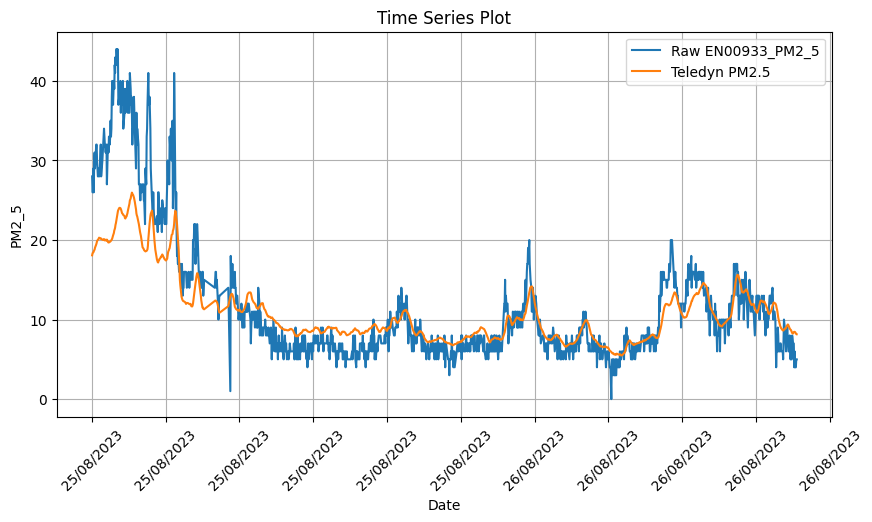

In [19]:
def plot_line_chart(df, sensor_id):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df['DataDate'], y=df['PM2_5'], label=f'Raw {sensor_id}_PM2_5')
    sns.lineplot(x=df['DataDate'], y=df['PM2.5'], label='Teledyn PM2.5')

    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('PM2_5')
    plt.grid(True)
    plt.legend()

    # Format the date on the x-axis to show hours and minutes (H:S)
    date_format = DateFormatter("%d/%m/%Y")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()
plot_line_chart(train_set, 'EN00933')